# Preparação do ambiente

## Bibliotecas

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import pandas as pd
import re
import unidecode

from datetime import datetime
from joblib import dump

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from string import punctuation

In [2]:
import warnings
warnings.filterwarnings("ignore") 

## Constantes e funções auxiliares

In [3]:
# MODELS_FOLDER = '../datasets/experimento_gs/best_models/'
FILE_MARKETPLACES = '../datasets/experimento_gs/marketplaces.parquet'
# FILE_SUPERVISAO_MERCADO = '../datasets/experimento_gs/supervisao_mercado.xlsx'
# FILE_HYPER_PARAMETERS_MODEL = '../datasets/experimento_gs/gs_hyper_paramenters_model.json'
# N_JOBS = 6

In [15]:
# arquivo com amostras rotuladas já tratadas
FILE_ANUNCIOS_ROTULADOS = '../datasets/rotulagem_consolidada/fiscaliza/anuncios_rotulados.parquet'

# arquivos com categorias dos anúncios 
# apenas link e categoria para eventual mesclagem
FILE_ANUNCIOS_CATEGORIA = '../datasets/rotulagem_consolidada/regulatron/tratados/anuncios_categoria.parquet'

# planilha com resultados da fiscalização de supervisão de mercado
FILE_SUPERVISAO_MERCADO = '../datasets/rotulagem_consolidada/supervisao_mercado/supervisao_mercado.xlsx'

In [4]:
def load_file_mercado(file_mercado=FILE_SUPERVISAO_MERCADO):
    dict_df_mercado = pd.read_excel(
    file_mercado,
    sheet_name=None,
    usecols=[2,8,10],
    names=['texto_busca', 'titulo', 'passivel_homologacao'],
    true_values=['Sim', 'sim'],
    false_values=['Não','não'],
    na_values=['-'])

    df_list = []
    for key in dict_df_mercado.keys():
        df = dict_df_mercado[key]
        df['marketplace'] = key
        df_list.append(df)
        
    df_mercado = pd.concat(df_list)
    df_mercado = df_mercado.dropna()
    df_mercado['passivel_homologacao'] = df_mercado['passivel_homologacao'].astype(int)
    
    map_marketplaces = {
        'Amazon': 'Amazon', 
        'Americanas': 'Lojas Americanas',
        'CasasBahia': 'Casas Bahia',
        'Magalu': 'Magazine Luiza', 
        'MercadoLivre': 'Mercado Livre'
    }
    
    df_mercado['marketplace'] = df_mercado['marketplace'].map(map_marketplaces)

    return df_mercado

In [5]:
def plot_model_performance(dataset='Padrão'):
    
    clf_name = pipe['clf'].__class__.__name__
    
    # test accuracy and roc_auc_score
    train_accuracy = pipe.score(X_train,y_train)
    test_accuracy = pipe.score(X_test,y_test)
    valid_accuracy = pipe.score(X_valid,y_valid)
    
    if hasattr(pipe['clf'],'predict_proba'):
        y_train_proba = pipe.predict_proba(X_test)[:,1]
        y_test_proba = pipe.predict_proba(X_test)[:,1]
        y_valid_proba = pipe.predict_proba(X_valid)[:,1]
    else:
        y_train_proba = pipe.decision_function(X_test)
        y_test_proba = pipe.decision_function(X_test)
        y_valid_proba = pipe.decision_function(X_valid)
        
    train_auc = roc_auc_score(y_test,y_test_proba)
    test_auc = roc_auc_score(y_test,y_test_proba)
    valid_auc = roc_auc_score(y_valid,y_valid_proba)
    
    
    print('Accuracy of {} classifier on training set: {:.3f}'.format(clf_name, train_accuracy))
    print('Accuracy of {} classifier on test set: {:.3f}'.format(clf_name, test_accuracy))
    print('Accuracy of {} classifier on validation set: {:.3f}'.format(clf_name, valid_accuracy))
    print('')
    print('AUC of {} classifier on training set: {:.3f}'.format(clf_name, train_auc))
    print('AUC of {} classifier on test set: {:.3f}'.format(clf_name, test_auc))
    print('AUC of {} classifier on validation set: {:.3f}'.format(clf_name, valid_auc))
    print('')
    
    # validation confusion matrix
    y_pred_test = pipe.predict(X_test)
    y_pred_valid = pipe.predict(X_valid)
    cm = confusion_matrix(y_valid,y_pred_valid)
    tn = int(cm[0][0])
    fn = int(cm[1][0])
    tp = int(cm[1][1])
    fp = int(cm[0][1])
    
    valid_confusion = {
        'tn': tn, 
        'fn': fn, 
        'tp': tp, 
        'fp': fp
    }
    
    
    model_performance = {
        'name': clf_name,
        'train_auc': train_auc,
        'train_accuracy': train_accuracy,
        'test_auc': test_auc, 
        'test_accuracy': test_accuracy,
        'valid_auc': valid_auc,
        'valid_accuracy': valid_accuracy,
        'valid_confusion': json.dumps(valid_confusion),
        'model': pipe
    }

    target_names_confusion = ['Não passíveis\nde homologação','Passíveis\nde homologação']
    
    fig, axs = plt.subplots(1,2,figsize=(16, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=axs[0])
    axs[0].set_xlabel('Verdadeiro')
    axs[0].set_ylabel('Predito')
    axs[0].xaxis.set_ticklabels(target_names_confusion)
    axs[0].yaxis.set_ticklabels(target_names_confusion)
    _ = axs[0].set_title(f'Matriz de Confusão {clf_name}\nConjunto de Teste')
    
    ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_valid, ax=axs[1])
    axs[1].set_xlabel('Verdadeiro')
    axs[1].set_ylabel('Predito')
    axs[1].xaxis.set_ticklabels(target_names_confusion)
    axs[1].yaxis.set_ticklabels(target_names_confusion)
    _ = axs[1].set_title(f'Matriz de Confusão {clf_name}\nConjunto de Validação')
    
    plt.show()

    return model_performance

In [6]:
def save_best_estimator():
    best_estimator_class_name = gs.best_estimator_['clf'].__class__.__name__
    best_estimator_file_name = f'{MODELS_FOLDER}{best_estimator_class_name}.joblib'
    dump(gs.best_estimator_,best_estimator_file_name)

# Carga e prepação dos dados

In [7]:
df_anuncios = pd.read_parquet(FILE_ANUNCIOS_ROTULADOS)
df_mercado = load_file_mercado()

# reduzir a base de dados para construir o notebook
# df_marketplaces = df_marketplaces.sample(10)

# conjunto de dados
docs_marketplaces = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['titulo'].values
targets_marketplaces = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['passivel_homologacao'].values

# Split data to keep experiment results comparable
X_train, X_test, y_train, y_test = train_test_split(
    docs_marketplaces, targets_marketplaces,
    test_size=0.25, 
    random_state=724
)

X_valid, y_valid = df_mercado['titulo'].values, df_mercado['passivel_homologacao'].values

In [14]:
df_marketplaces

,id,marketplace,titulo,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto
0,125728,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,1,1,1,1,1,1,TV Box/TV Stick
1,125729,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,1,1,1,1,1,1,Smartphones
2,125730,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,1,1,1,1,1,1,Computador ou notebook
3,125731,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
4,125732,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",1,1,1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
...,...,...,...,...,...,...,...,...,...,...,...
18831,125715,amazon,CAIXA ACUSTICA PCX6500,,0,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
18832,125716,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima)
18833,125717,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
18834,125718,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)


# Análise


## Treinamento com dados originais

In [8]:
models = []

### LogisticRegression

Accuracy of LogisticRegression classifier on training set: 0.996
Accuracy of LogisticRegression classifier on test set: 0.920
Accuracy of LogisticRegression classifier on validation set: 0.898

AUC of LogisticRegression classifier on training set: 0.974
AUC of LogisticRegression classifier on test set: 0.974
AUC of LogisticRegression classifier on validation set: 0.953



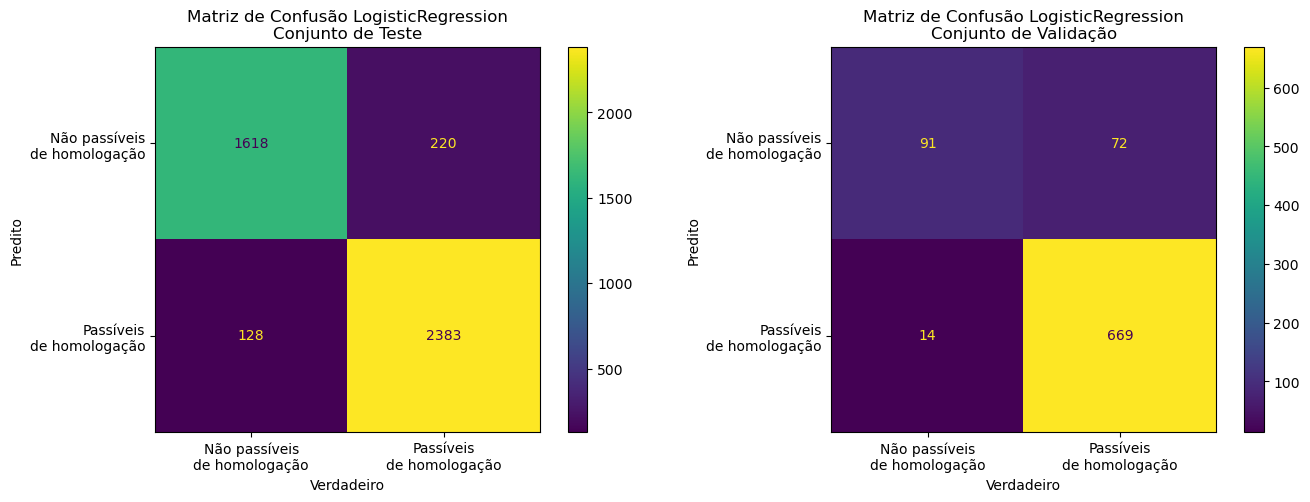

CPU times: total: 6.38 s
Wall time: 3.1 s


In [9]:
%%time
vectorizer = TfidfVectorizer(
    strip_accents = 'unicode', 
    ngram_range = (1,2)
)

clf = LogisticRegression(C=10)

pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X_train,y_train)

models.append(plot_model_performance())

### LinearSVC

Accuracy of LinearSVC classifier on training set: 0.997
Accuracy of LinearSVC classifier on test set: 0.924
Accuracy of LinearSVC classifier on validation set: 0.900

AUC of LinearSVC classifier on training set: 0.974
AUC of LinearSVC classifier on test set: 0.974
AUC of LinearSVC classifier on validation set: 0.952



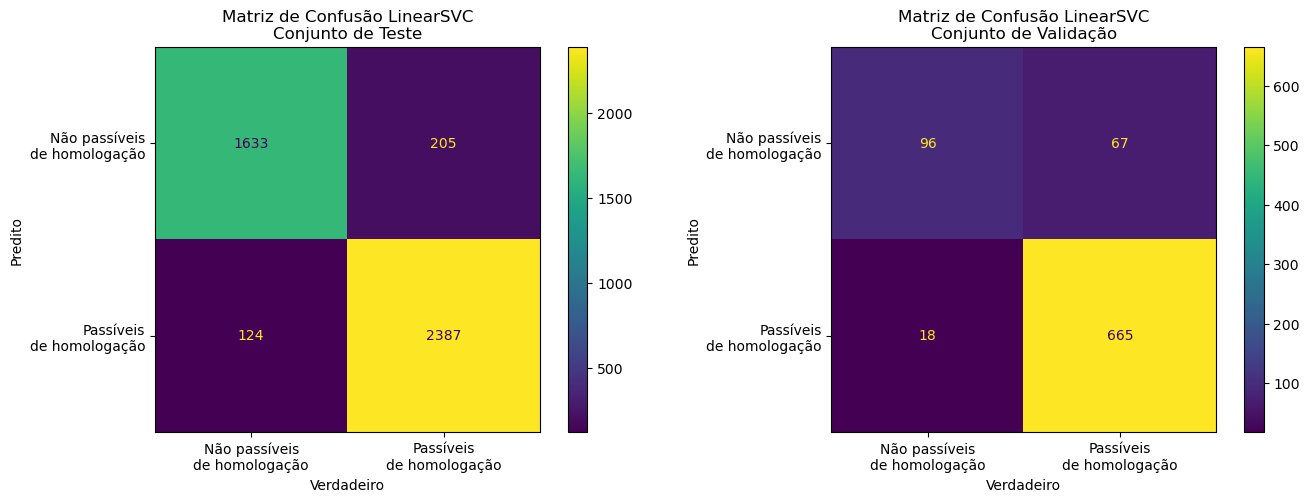

CPU times: total: 2.11 s
Wall time: 2.31 s


In [10]:
%%time
vectorizer = TfidfVectorizer(
    strip_accents = 'unicode', 
    ngram_range = (1,2)
)

clf = LinearSVC()

pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X_train,y_train)

models.append(plot_model_performance())

### SGDClassifier

Accuracy of SGDClassifier classifier on training set: 0.995
Accuracy of SGDClassifier classifier on test set: 0.921
Accuracy of SGDClassifier classifier on validation set: 0.898

AUC of SGDClassifier classifier on training set: 0.974
AUC of SGDClassifier classifier on test set: 0.974
AUC of SGDClassifier classifier on validation set: 0.953



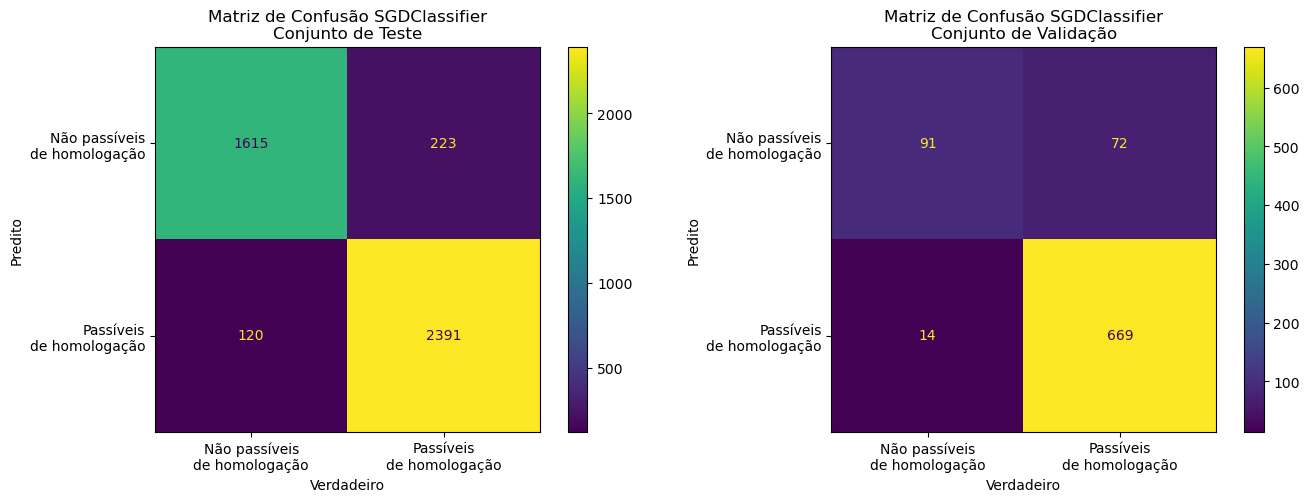

CPU times: total: 2.72 s
Wall time: 2.26 s


In [11]:
%%time
vectorizer = TfidfVectorizer(
    strip_accents = 'unicode', 
    ngram_range = (1,2)
)

clf = SGDClassifier(loss = 'log_loss',alpha = 1e-05)

pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X_train,y_train)

models.append(plot_model_performance())

### NuSVC

Accuracy of NuSVC classifier on training set: 0.998
Accuracy of NuSVC classifier on test set: 0.924
Accuracy of NuSVC classifier on validation set: 0.901

AUC of NuSVC classifier on training set: 0.973
AUC of NuSVC classifier on test set: 0.973
AUC of NuSVC classifier on validation set: 0.952



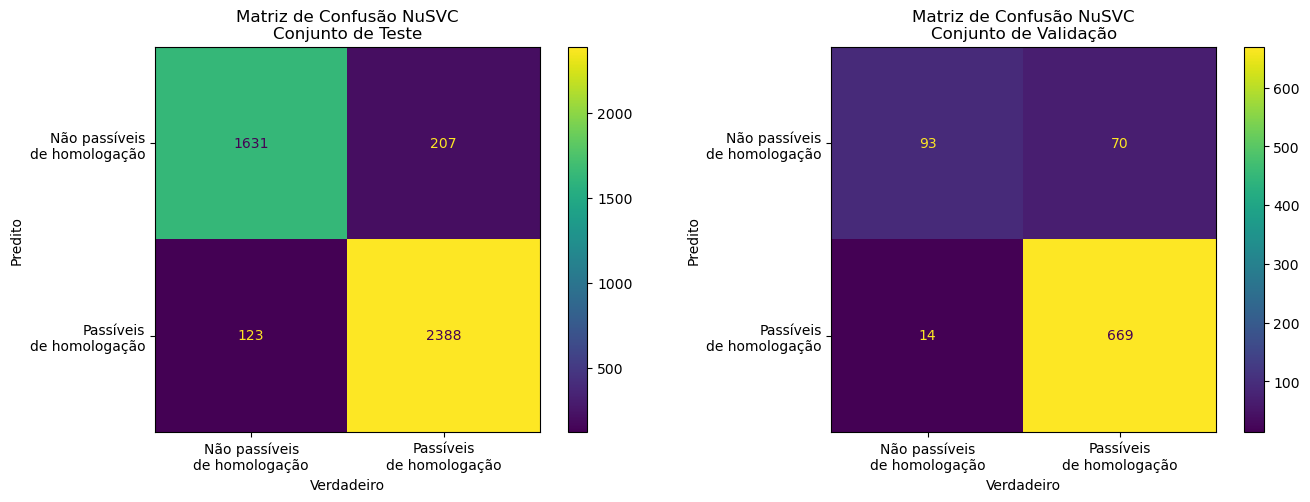

CPU times: total: 1min 24s
Wall time: 1min 27s


In [12]:
%%time
vectorizer = TfidfVectorizer(
    strip_accents = 'unicode', 
    ngram_range = (1,2)
)

clf = NuSVC(nu = 0.25, tol = 0.01)

pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X_train,y_train)

models.append(plot_model_performance())

### Resultados do treinamento com dados originais

In [13]:
df_models = pd.DataFrame(models)
df_models = df_models.sort_values(by='valid_auc', ascending = False)
df_models

,name,train_auc,train_accuracy,test_auc,test_accuracy,valid_auc,valid_accuracy,valid_confusion,model
2,SGDClassifier,0.973975,0.995247,0.973975,0.921131,0.953319,0.898345,"{""tn"": 91, ""fn"": 14, ""tp"": 669, ""fp"": 72}","(TfidfVectorizer(ngram_range=(1, 2), strip_acc..."
0,LogisticRegression,0.974051,0.995784,0.974051,0.919982,0.953121,0.898345,"{""tn"": 91, ""fn"": 14, ""tp"": 669, ""fp"": 72}","(TfidfVectorizer(ngram_range=(1, 2), strip_acc..."
3,NuSVC,0.973177,0.998390,0.973177,0.924120,0.952142,0.900709,"{""tn"": 93, ""fn"": 14, ""tp"": 669, ""fp"": 70}","(TfidfVectorizer(ngram_range=(1, 2), strip_acc..."
1,LinearSVC,0.973941,0.997394,0.973941,0.924350,0.952115,0.899527,"{""tn"": 96, ""fn"": 18, ""tp"": 665, ""fp"": 67}","(TfidfVectorizer(ngram_range=(1, 2), strip_acc..."


## Análise de desempenho com informações adicionais no conjunto de dados